total trades 92.0


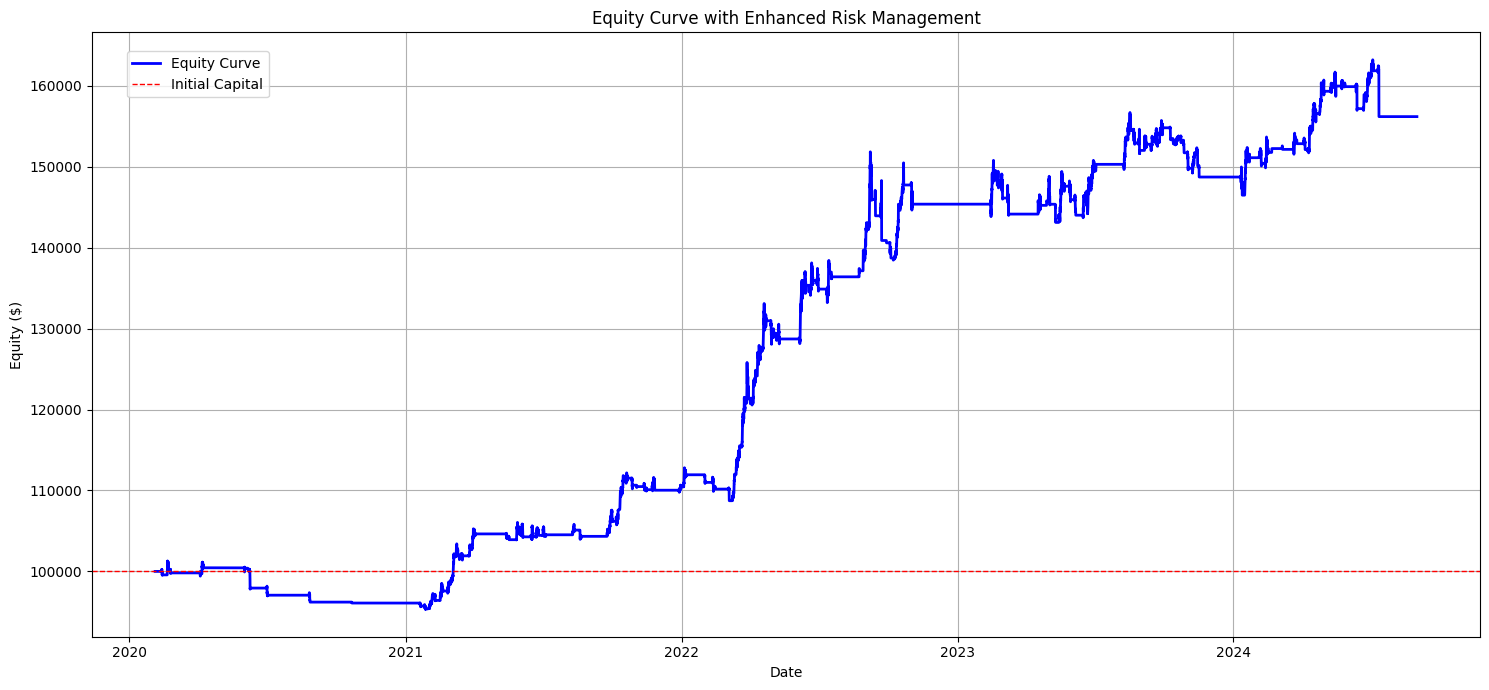

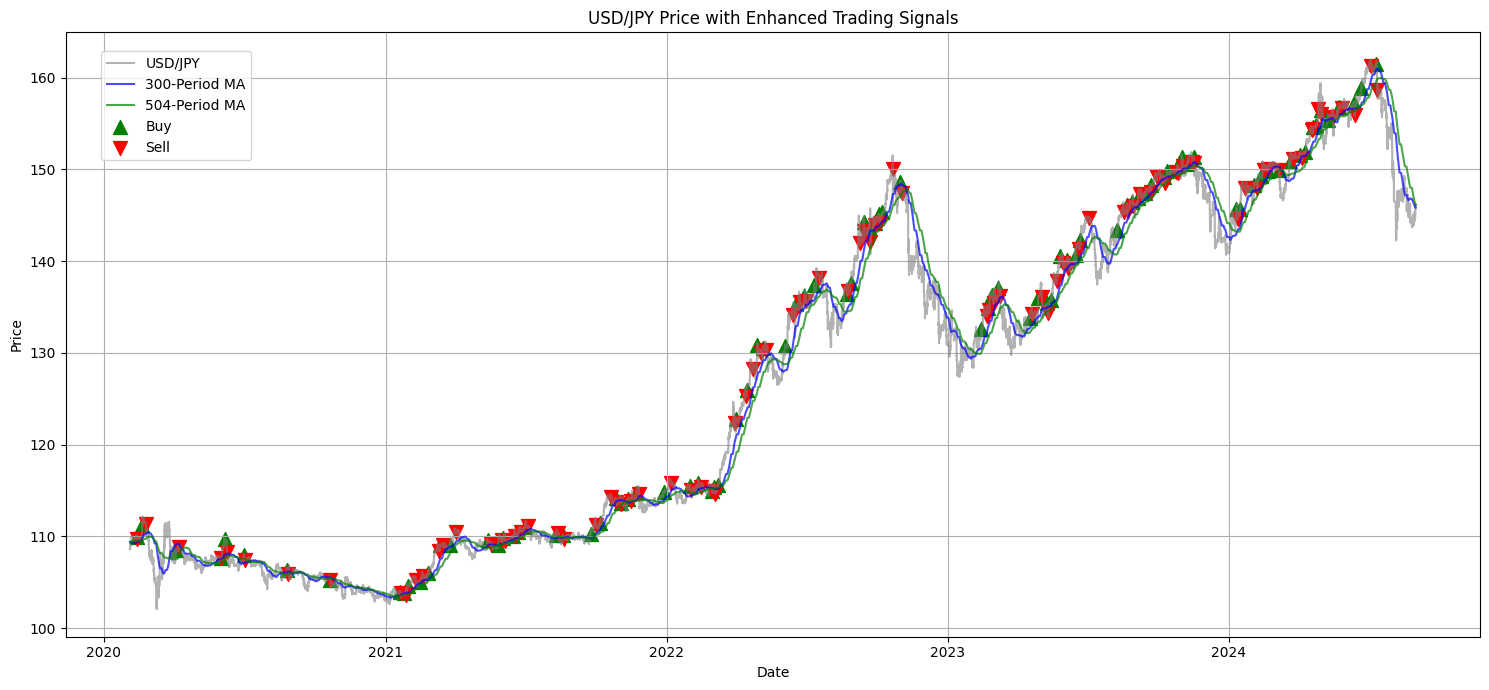


COMPREHENSIVE PERFORMANCE REPORT

1. Monthly Return Statistics:
Average Monthly Return: 0.86%
Monthly Return Std Dev: 2.43%
Best Month: 10.20%
Worst Month: -3.11%
Positive Months: 27 (50.0%)
Negative Months: 18
Monthly Volatility: 2.43%

2. Overall Performance Metrics:
Initial Capital: $100,000.00
Final Capital: $156,211.27
Total Return: 56.21%
Annualized Return: 10.24%
Total Months: 54
Total Trades: 92
Trade Win Rate: 47.83%

3. Risk Metrics:
Maximum Drawdown: -8.82%
Average Drawdown: -2.79%
Longest Drawdown Duration: 6459.0 hours (269.1 days)
Annual Volatility: 7.44%

4. Risk-Adjusted Returns:
Monthly Sharpe Ratio (Annualized): 0.99
Monthly Sortino Ratio (Annualized): 2.41
Calmar Ratio: 1.16
Profit Factor: 1.97

5. Trade Statistics:
Average Profit per Trade: $610.99
Median Profit per Trade: $-69.38
Largest Win: $12,679.54
Largest Loss: $-5,670.57
Win/Loss Ratio: 2.15

6. Exit Analysis:

Exit Reason Analysis:
                                                    Count  Total_Profit  \


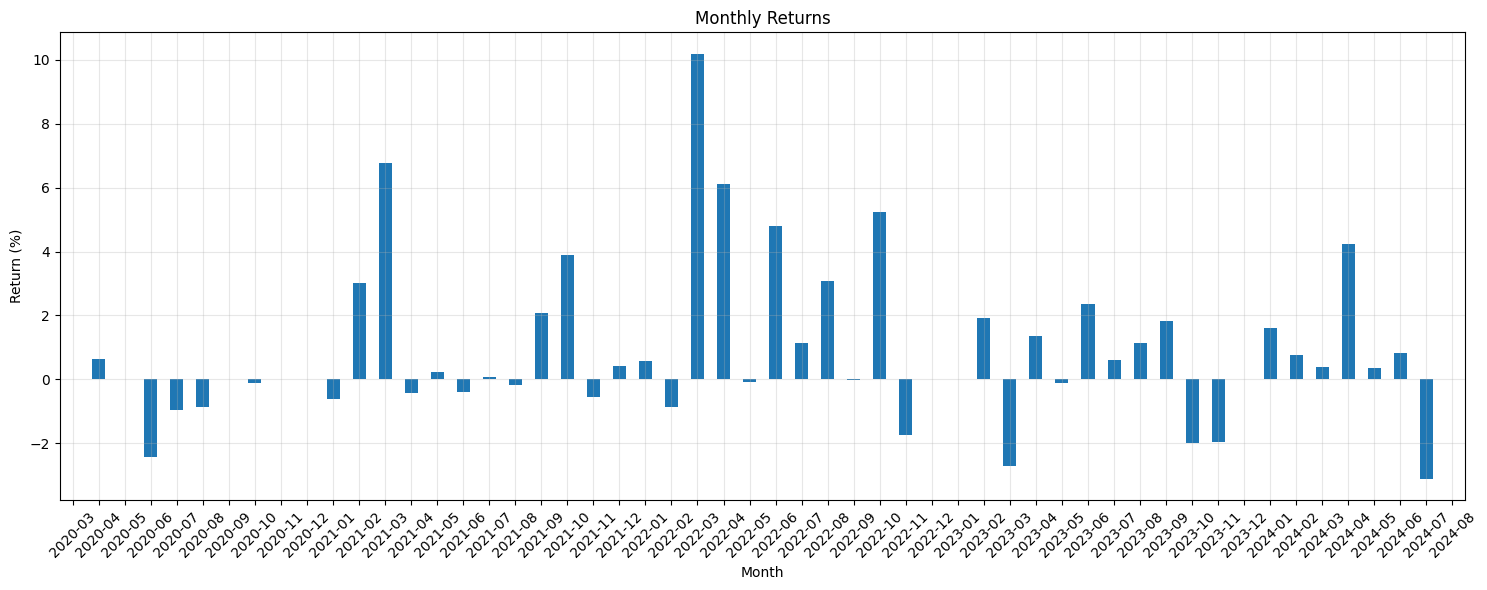

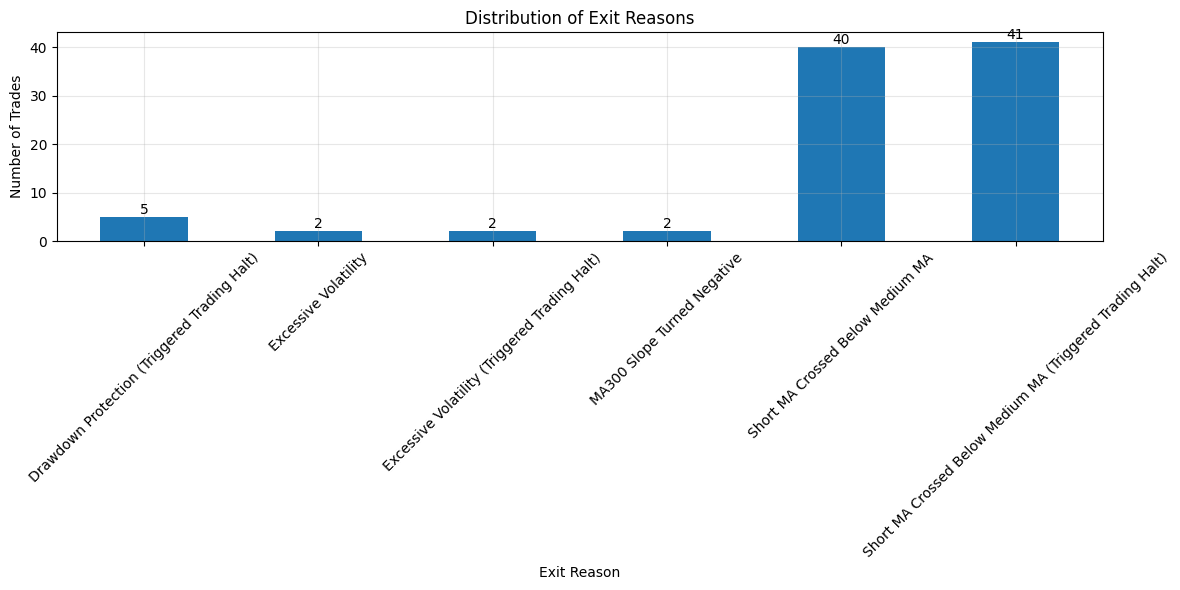

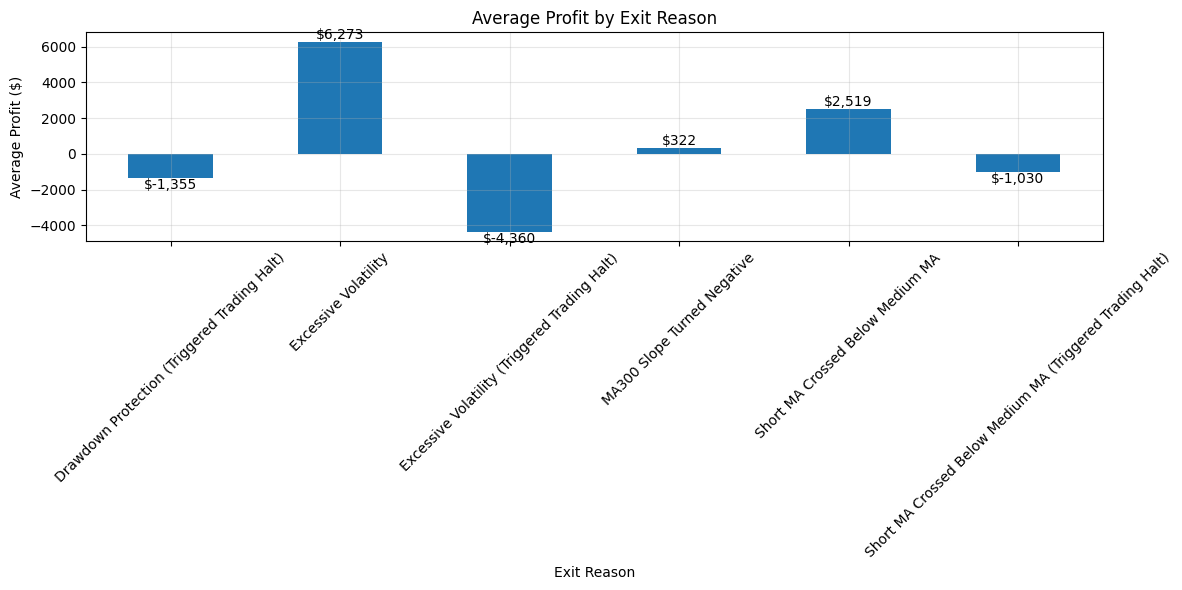

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange

# Constants and Parameters
INITIAL_CAPITAL = 100000
LEVERAGE = 2
TRAILING_STOP_PERCENTAGE = 0.03  # 3%
DRAWDOWN_LIMIT = 0.05         # 6%
WEEKLY_TRADE_LIMIT = 7
ADX_THRESHOLD = 25
RSI_LOWER_LIMIT = 30
RSI_UPPER_LIMIT = 70
CONSECUTIVE_LOSSES_LIMIT = 1

class RiskManager:
    def __init__(self, initial_capital):
        self.initial_capital = initial_capital
        self.peak_capital = initial_capital
        self.drawdown_limit = DRAWDOWN_LIMIT
        
    def update_peak_capital(self, current_capital):
        self.peak_capital = max(self.peak_capital, current_capital)
        
    def check_drawdown(self, current_capital):
        drawdown = (self.peak_capital - current_capital) / self.peak_capital
        return drawdown <= self.drawdown_limit
        
    def reset_peak_capital(self, current_equity):
        self.peak_capital = current_equity
    
    def get_minimum_equity(self):
        return self.peak_capital * (1 - self.drawdown_limit)

class ForexCalculator:
    @staticmethod
    def calculate_profit_usd(entry_price, exit_price, position_size):
        pip_value = 0.01
        pips_gained = (exit_price - entry_price) / pip_value
        profit = (pips_gained * pip_value) * position_size
        return profit

    @staticmethod
    def calculate_trailing_stop_price(highest_price, trailing_stop_percentage):
        return highest_price * (1 - trailing_stop_percentage)

def prepare_data(file_path):
    data = pd.read_csv(file_path)
    data['local_time_GMT'] = pd.to_datetime(data['local_time_GMT'])
    data = data.sort_values(by='local_time_GMT').reset_index(drop=True)
    
    # Calculate moving averages
    data['MA_short'] = data['USDJPY_Close'].rolling(window=15).mean()
    data['MA_medium'] = data['USDJPY_Close'].rolling(window=80).mean()
    data['MA_long'] = data['USDJPY_Close'].rolling(window=150).mean()
    data['MA_300'] = data['USDJPY_Close'].rolling(window=300).mean()
    data['MA_504'] = data['USDJPY_Close'].rolling(window=504).mean()
    
    # Calculate MA slopes using linear regression
    def calculate_slope(series, window):
        slopes = []
        for i in range(len(series)):
            if i < window:
                slopes.append(np.nan)
                continue
            y = series.iloc[i-window:i]
            x = np.arange(window)
            slope, _ = np.polyfit(x, y, 1)
            slopes.append(slope)
        return pd.Series(slopes, index=series.index)
    
    # Calculate slopes for both MAs
    data['MA_300_Slope'] = calculate_slope(data['MA_300'], 48)
    data['MA_504_Slope'] = calculate_slope(data['MA_504'], 48)
    
    # Technical indicators
    adx = ADXIndicator(high=data['USDJPY_High'], 
                      low=data['USDJPY_Low'], 
                      close=data['USDJPY_Close'], 
                      window=14)
    data['ADX'] = adx.adx()
    
    rsi = RSIIndicator(close=data['USDJPY_Close'], window=20)
    data['RSI'] = rsi.rsi()
    
    atr = AverageTrueRange(high=data['USDJPY_High'], 
                          low=data['USDJPY_Low'], 
                          close=data['USDJPY_Close'], 
                          window=14)
    data['ATR'] = atr.average_true_range()
    
    # Compute 20-period rolling average of ATR
    data['ATR_MA20'] = data['ATR'].rolling(window=20).mean()
    
    # Add week number for trade limiting
    data['Week_Number'] = data['local_time_GMT'].dt.isocalendar().week
    
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    return data

class TradingStrategy:
    def __init__(self, initial_capital):
        self.capital = initial_capital
        self.current_equity = initial_capital
        self.risk_manager = RiskManager(initial_capital)
        self.forex_calculator = ForexCalculator()
        self.trade_log = []
        self.equity_curve = []
        self.current_position = 0
        self.entry_price = None
        self.highest_price = None
        self.trailing_stop_price = None
        self.weekly_trade_count = 0
        self.trading_halted = False
        self.consecutive_losses = 0
        self.current_index = 0
        self.unrealized_pnl = 0
        self.max_position_risk = 0.02
        self.halt_start_time = None
        self.waiting_period_hours = 72

    def calculate_current_equity(self, current_price):
        if self.current_position > 0:
            self.unrealized_pnl = self.forex_calculator.calculate_profit_usd(
                self.entry_price, current_price, self.current_position
            )
            self.current_equity = self.capital + self.unrealized_pnl
        else:
            self.unrealized_pnl = 0
            self.current_equity = self.capital
            
        return self.current_equity
        
    def calculate_position_size(self, current_price, current_atr):
        risk_amount = self.capital * self.max_position_risk
        position_size = (risk_amount / (current_atr * 3.0)) * current_price
        return min(position_size, (self.capital * LEVERAGE) / current_price)
    
    def check_entry_conditions(self, row):
        ma_conditions = (
            row['MA_short'] > row['MA_medium'] and 
            row['MA_short'] > row['MA_long'] and
            row['MA_300_Slope'] > 0 and
            row['MA_504_Slope'] > 0
        )
        
        technical_conditions = (
            row['ADX'] > ADX_THRESHOLD and
            RSI_LOWER_LIMIT < row['RSI'] < RSI_UPPER_LIMIT
        )
        
        volatility_condition = row['ATR'] < row['ATR_MA20'] * 1.5
        
        return ma_conditions and technical_conditions and volatility_condition
        # you can check the strength of signal and then decide positioj sizing 
        # if very strong signal; then go big 
        # But if signal is weak; then reduce leevrage or go soft 
        
    
    def check_exit_conditions(self, row, current_price):
        if self.current_position == 0:
            return False, None

        if current_price <= self.trailing_stop_price:
            return True, 'Trailing Stop Hit'

        if row['MA_short'] < row['MA_medium']:
            return True, 'Short MA Crossed Below Medium MA'

        if row['MA_300_Slope'] < 0:
            return True, 'MA300 Slope Turned Negative'

        if row['ATR'] > row['ATR_MA20'] * 2:
            return True, 'Excessive Volatility'

        return False, None
    
    
    def check_waiting_period(self, current_time):
        if self.halt_start_time is None:
            return True
        
        time_difference = current_time - self.halt_start_time
        hours_passed = time_difference.total_seconds() / 3600
        return hours_passed >= self.waiting_period_hours
    
    def check_market_conditions(self, row):
        return (
            row['MA_300_Slope'] > 0 and 
            row['MA_504_Slope'] > 0 and
            row['ADX'] > ADX_THRESHOLD and
            RSI_LOWER_LIMIT < row['RSI'] < RSI_UPPER_LIMIT
        )
    
    def execute_trade(self, data):
        for i in range(1, len(data)):
            self.current_index = i
            current_price = data.iloc[i]['USDJPY_Close']
            current_date = data.iloc[i]['local_time_GMT']
            
            current_equity = self.calculate_current_equity(current_price)
            
            self.equity_curve.append({
                'Date': current_date,
                'Equity': current_equity,
                'Unrealized_PnL': self.unrealized_pnl
            })
            
            self.risk_manager.update_peak_capital(current_equity)
            
            if current_equity < self.risk_manager.get_minimum_equity():
                if self.current_position > 0:
                    self._close_position(current_price, current_date, 'Drawdown Protection')
                    self.risk_manager.reset_peak_capital(current_equity)
                    self.trading_halted = True
                continue
            
            if i > 0 and data.iloc[i]['Week_Number'] != data.iloc[i-1]['Week_Number']:
                self.weekly_trade_count = 0
            
            if self.trading_halted:
                waiting_period_elapsed = self.check_waiting_period(current_date)
                market_conditions_favorable = self.check_market_conditions(data.iloc[i])
                
                if waiting_period_elapsed and market_conditions_favorable:
                    self.trading_halted = False
                    self.consecutive_losses = 0
                    self.halt_start_time = None
                else:
                    if self.current_position > 0:
                        self.manage_position(current_price, current_date, data.iloc[i])
                    continue
            
            if self.current_position > 0:
                self.manage_position(current_price, current_date, data.iloc[i])
                continue
            
            if (self.current_position == 0 and 
                self.weekly_trade_count < WEEKLY_TRADE_LIMIT and 
                self.check_entry_conditions(data.iloc[i])):
                
                self._open_position(current_price, current_date, data.iloc[i])
                self.weekly_trade_count += 1

    def manage_position(self, current_price, current_date, row):
        if current_price > self.highest_price:
            self.highest_price = current_price
            self.trailing_stop_price = self.forex_calculator.calculate_trailing_stop_price(
                self.highest_price, TRAILING_STOP_PERCENTAGE
            )

        should_exit, exit_reason = self.check_exit_conditions(row, current_price)
        if should_exit:
            self._close_position(current_price, current_date, exit_reason)
            
    
    
    def _open_position(self, price, date, row):
        self.entry_price = price
        self.current_position = self.calculate_position_size(price, row['ATR'])
        
        self.trailing_stop_price = self.forex_calculator.calculate_trailing_stop_price(
            price, TRAILING_STOP_PERCENTAGE
        )
        self.highest_price = price
        
        self.trade_log.append({
            'Type': 'Buy',
            'Date': date,
            'Price': price,
            'Position_Size': self.current_position,
            'Capital': self.capital,
            'Trailing_Stop': self.trailing_stop_price,
            'ATR': row['ATR']
        })
    
    def _close_position(self, price, date, reason):
        profit = self.forex_calculator.calculate_profit_usd(
            self.entry_price, price, self.current_position
        )
        self.capital += profit

        if profit < 0:
            self.consecutive_losses += 1
        else:
            self.consecutive_losses = 0

        if self.consecutive_losses >= CONSECUTIVE_LOSSES_LIMIT and not self.trading_halted:
            self.trading_halted = True
            self.halt_start_time = date
            reason = f"{reason} (Triggered Trading Halt)"

        self.trade_log.append({
            'Type': 'Sell',
            'Date': date,
            'Price': price,
            'Profit': profit,
            'Capital': self.capital,
            'Exit_Reason': reason
        })

        self.current_position = 0
        self.entry_price = None
        self.highest_price = None
        self.trailing_stop_price = None
        self.unrealized_pnl = 0        
        
def analyze_performance(trade_log_df, strategy, equity_curve_df, data):
    
    trades = trade_log_df[trade_log_df['Type'] == 'Sell'].copy()
    equity_series = equity_curve_df['Equity']
    
    # Convert timestamps to datetime if they aren't already
    equity_curve_df['Date'] = pd.to_datetime(equity_curve_df['Date'])
    
    # Add month-end flag and calculate monthly returns
    equity_curve_df['YearMonth'] = equity_curve_df['Date'].dt.to_period('M')
    monthly_returns = equity_curve_df.groupby('YearMonth')['Equity'].agg(['first', 'last']).pct_change()
    monthly_returns = (monthly_returns['last'] * 100).dropna()
    
    # 1. Basic Performance Metrics
    final_capital = strategy.capital
    total_return = (final_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    total_trades = len(trades)
    profitable_trades = len(trades[trades['Profit'] > 0])
    win_rate = (profitable_trades / total_trades * 100) if total_trades > 0 else 0
    
    # 2. Exit Analysis
    exit_analysis = trades.groupby('Exit_Reason').agg({
        'Profit': ['count', 'sum', 'mean', lambda x: (x > 0).sum() / len(x) * 100],
    }).round(2)
    
    exit_analysis.columns = ['Count', 'Total_Profit', 'Avg_Profit', 'Win_Rate_%']
      
    # 2. Time-Adjusted Return Metrics
    total_hours = (equity_curve_df['Date'].max() - equity_curve_df['Date'].min()).total_seconds() / 3600
    total_days = total_hours / 24
    total_years = total_days / 365
    
    # Monthly Return Statistics
    avg_monthly_return = monthly_returns.mean()
    monthly_return_std = monthly_returns.std()
    best_month = monthly_returns.max()
    worst_month = monthly_returns.min()
    positive_months = len(monthly_returns[monthly_returns > 0])
    negative_months = len(monthly_returns[monthly_returns < 0])
    total_months = len(monthly_returns)
    monthly_win_rate = (positive_months / total_months * 100) if total_months > 0 else 0
    
    # Annualized Return (adjusted for actual months)
    annual_return = ((1 + total_return/100) ** (1/total_years) - 1) * 100
    
    # Calculate hourly returns for intraday analysis
    equity_curve_df['Hourly_Returns'] = equity_curve_df['Equity'].pct_change()
    
    # 3. Risk Metrics
    hourly_volatility = equity_curve_df['Hourly_Returns'].std()
    daily_volatility = hourly_volatility * np.sqrt(24)
    annual_volatility = daily_volatility * np.sqrt(252)
    monthly_volatility = monthly_return_std
    
    # Drawdown Analysis
    equity_curve_df['Peak'] = equity_curve_df['Equity'].expanding().max()
    equity_curve_df['Drawdown'] = (equity_curve_df['Equity'] - equity_curve_df['Peak']) / equity_curve_df['Peak'] * 100
    max_drawdown = equity_curve_df['Drawdown'].min()
    avg_drawdown = equity_curve_df[equity_curve_df['Drawdown'] < 0]['Drawdown'].mean()
    
    # Drawdown duration
    drawdown_duration_hours = equity_curve_df[equity_curve_df['Drawdown'] < 0].groupby(
        (equity_curve_df['Drawdown'] >= 0).cumsum()
    ).size().max()
    
    # 4. Risk-Adjusted Returns
    annual_risk_free_rate = 0.02  # 2% annual
    monthly_risk_free_rate = (1 + annual_risk_free_rate) ** (1/12) - 1
    
    # Monthly Sharpe and Sortino Ratios
    monthly_excess_returns = monthly_returns/100 - monthly_risk_free_rate
    monthly_sharpe = monthly_excess_returns.mean() / monthly_excess_returns.std() * np.sqrt(12)
    
    negative_monthly_returns = monthly_returns[monthly_returns < 0]/100
    monthly_sortino = (monthly_returns.mean()/100 - monthly_risk_free_rate) / negative_monthly_returns.std() * np.sqrt(12)
    
    # Calmar Ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.inf
    
    # 5. Trade Statistics
    avg_profit = trades['Profit'].mean()
    median_profit = trades['Profit'].median()
    profit_std = trades['Profit'].std()
    largest_win = trades['Profit'].max()
    largest_loss = trades['Profit'].min()
    
    avg_win = trades[trades['Profit'] > 0]['Profit'].mean()
    avg_loss = trades[trades['Profit'] < 0]['Profit'].mean()
    win_loss_ratio = abs(avg_win/avg_loss) if avg_loss != 0 else np.inf
    
    gross_profits = trades[trades['Profit'] > 0]['Profit'].sum()
    gross_losses = abs(trades[trades['Profit'] < 0]['Profit'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else np.inf
    
    print("\n" + "="*50)
    print("COMPREHENSIVE PERFORMANCE REPORT")
    print("="*50)
    
    print("\n1. Monthly Return Statistics:")
    print(f"Average Monthly Return: {avg_monthly_return:.2f}%")
    print(f"Monthly Return Std Dev: {monthly_return_std:.2f}%")
    print(f"Best Month: {best_month:.2f}%")
    print(f"Worst Month: {worst_month:.2f}%")
    print(f"Positive Months: {positive_months} ({monthly_win_rate:.1f}%)")
    print(f"Negative Months: {negative_months}")
    print(f"Monthly Volatility: {monthly_volatility:.2f}%")
    
    print("\n2. Overall Performance Metrics:")
    print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annual_return:.2f}%")
    print(f"Total Months: {total_months}")
    print(f"Total Trades: {total_trades}")
    print(f"Trade Win Rate: {win_rate:.2f}%")
    
    print("\n3. Risk Metrics:")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Average Drawdown: {avg_drawdown:.2f}%")
    print(f"Longest Drawdown Duration: {drawdown_duration_hours:.1f} hours ({drawdown_duration_hours/24:.1f} days)")
    print(f"Annual Volatility: {annual_volatility*100:.2f}%")
    
    print("\n4. Risk-Adjusted Returns:")
    print(f"Monthly Sharpe Ratio (Annualized): {monthly_sharpe:.2f}")
    print(f"Monthly Sortino Ratio (Annualized): {monthly_sortino:.2f}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    
    print("\n5. Trade Statistics:")
    print(f"Average Profit per Trade: ${avg_profit:,.2f}")
    print(f"Median Profit per Trade: ${median_profit:,.2f}")
    print(f"Largest Win: ${largest_win:,.2f}")
    print(f"Largest Loss: ${largest_loss:,.2f}")
    print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")

    print("\n6. Exit Analysis:")
    print("\nExit Reason Analysis:")
    print(exit_analysis)
    print("\nDetailed Exit Analysis:")
    for reason in exit_analysis.index:
        total_exits = exit_analysis.loc[reason, 'Count']
        win_rate = exit_analysis.loc[reason, 'Win_Rate_%']
        avg_profit = exit_analysis.loc[reason, 'Avg_Profit']
        total_profit = exit_analysis.loc[reason, 'Total_Profit']
        
        print(f"\n{reason}:")
        print(f"  Number of exits: {total_exits} ({(total_exits/total_trades*100):.1f}% of all trades)")
        print(f"  Win rate: {win_rate:.1f}%")
        print(f"  Average profit: ${avg_profit:,.2f}")
        print(f"  Total profit contribution: ${total_profit:,.2f}")
    
    # Monthly returns visualization
    plt.figure(figsize=(15, 6))
    monthly_returns.plot(kind='bar')
    plt.title('Monthly Returns')
    plt.xlabel('Month')
    plt.ylabel('Return (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Exit Analysis Visualization
    plt.figure(figsize=(12, 6))
    exit_counts = exit_analysis['Count'].plot(kind='bar')
    plt.title('Distribution of Exit Reasons')
    plt.xlabel('Exit Reason')
    plt.ylabel('Number of Trades')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add value labels on top of each bar
    for i, v in enumerate(exit_analysis['Count']):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Profit by Exit Reason Visualization
    plt.figure(figsize=(12, 6))
    exit_analysis['Avg_Profit'].plot(kind='bar')
    plt.title('Average Profit by Exit Reason')
    plt.xlabel('Exit Reason')
    plt.ylabel('Average Profit ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add value labels on top of each bar
    for i, v in enumerate(exit_analysis['Avg_Profit']):
        plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'avg_monthly_return': avg_monthly_return,
        'monthly_sharpe': monthly_sharpe,
        'monthly_sortino': monthly_sortino,
        'max_drawdown': max_drawdown,
        'profit_factor': profit_factor,
        'win_rate': win_rate,
        'monthly_win_rate': monthly_win_rate,
        'exit_analysis': exit_analysis
    }

def main():
    data = prepare_data('USDJPY.csv')
    strategy = TradingStrategy(INITIAL_CAPITAL)
    strategy.execute_trade(data)
    
    trade_log_df = pd.DataFrame(strategy.trade_log)
    print("total trades " + str(len(trade_log_df)/2))
    equity_curve_df = pd.DataFrame(strategy.equity_curve)
    
    # Plotting Equity Curve with left-side legend
    plt.figure(figsize=(15, 7))
    plt.plot(equity_curve_df['Date'], equity_curve_df['Equity'], 
             label='Equity Curve', color='blue', linewidth=2)
    plt.axhline(y=INITIAL_CAPITAL, color='r', linestyle='--', 
                label='Initial Capital', linewidth=1)
    plt.title('Equity Curve with Enhanced Risk Management')
    plt.xlabel('Date')
    plt.ylabel('Equity ($)')
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Price Chart with Signals with left-side legend
    plt.figure(figsize=(15, 7))
    plt.plot(data['local_time_GMT'], data['USDJPY_Close'], 
             label='USD/JPY', color='gray', alpha=0.6)
    plt.plot(data['local_time_GMT'], data['MA_300'], 
             label='300-Period MA', color='blue', alpha=0.7)
    plt.plot(data['local_time_GMT'], data['MA_504'], 
             label='504-Period MA', color='green', alpha=0.7)
    
    buy_signals = trade_log_df[trade_log_df['Type'] == 'Buy']
    sell_signals = trade_log_df[trade_log_df['Type'] == 'Sell']
    
    plt.scatter(buy_signals['Date'], buy_signals['Price'], 
               marker='^', color='g', s=100, label='Buy')
    plt.scatter(sell_signals['Date'], sell_signals['Price'], 
               marker='v', color='r', s=100, label='Sell')
    
    plt.title('USD/JPY Price with Enhanced Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Run performance analysis
    analyze_performance(trade_log_df, strategy, equity_curve_df, data)

if __name__ == "__main__":
    main()

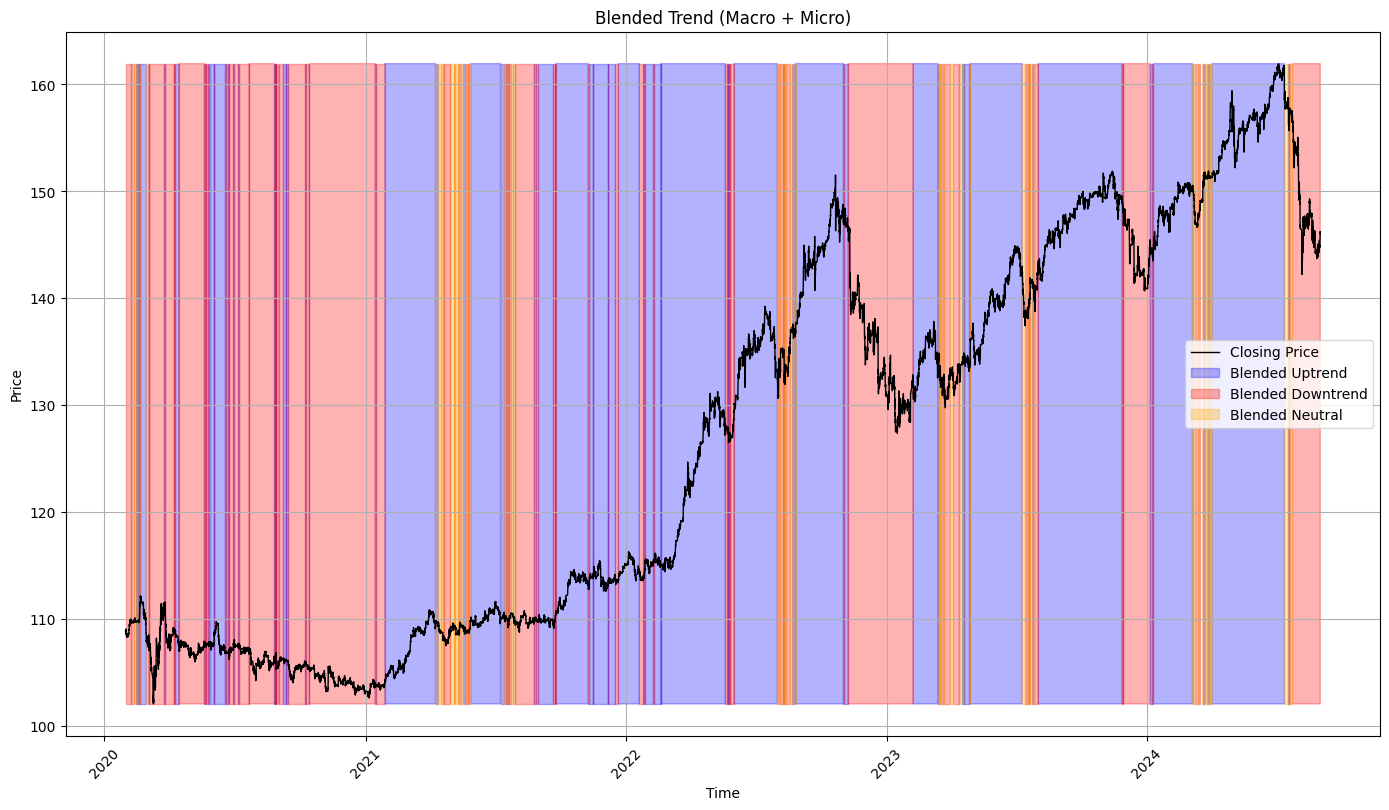

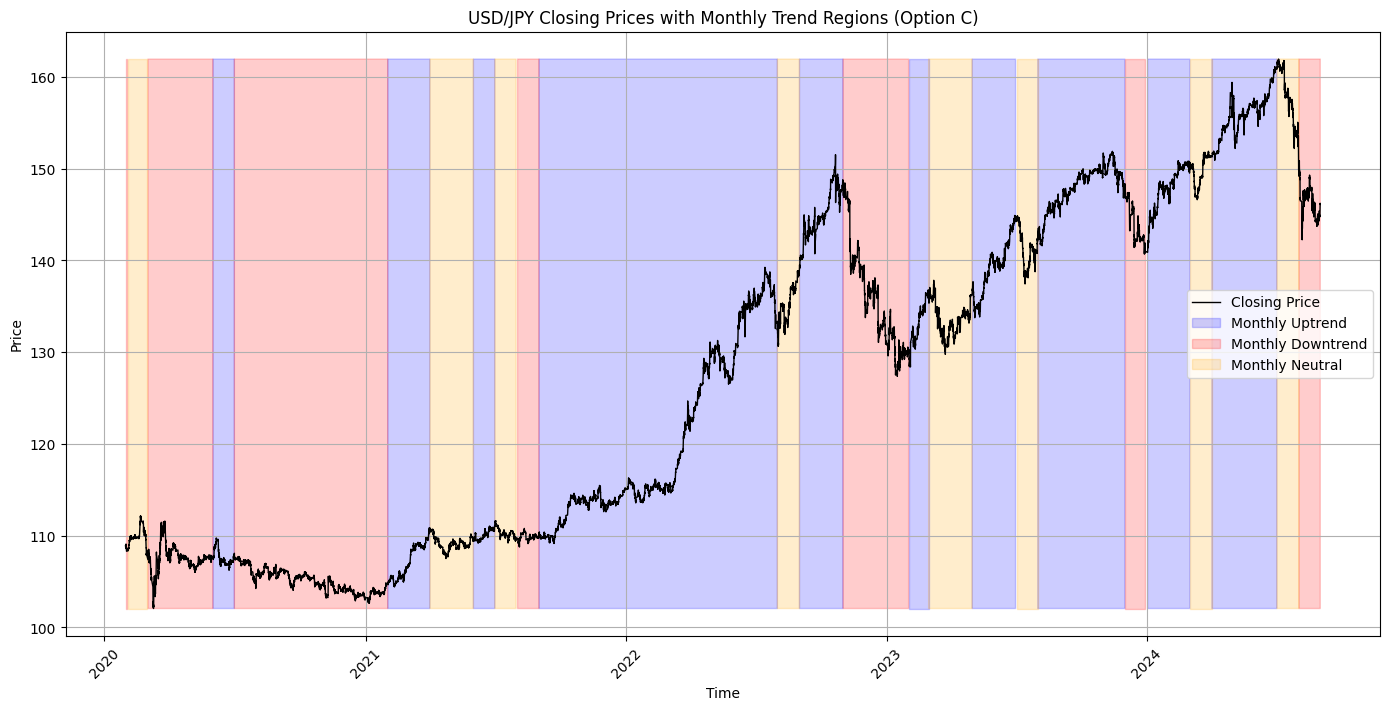

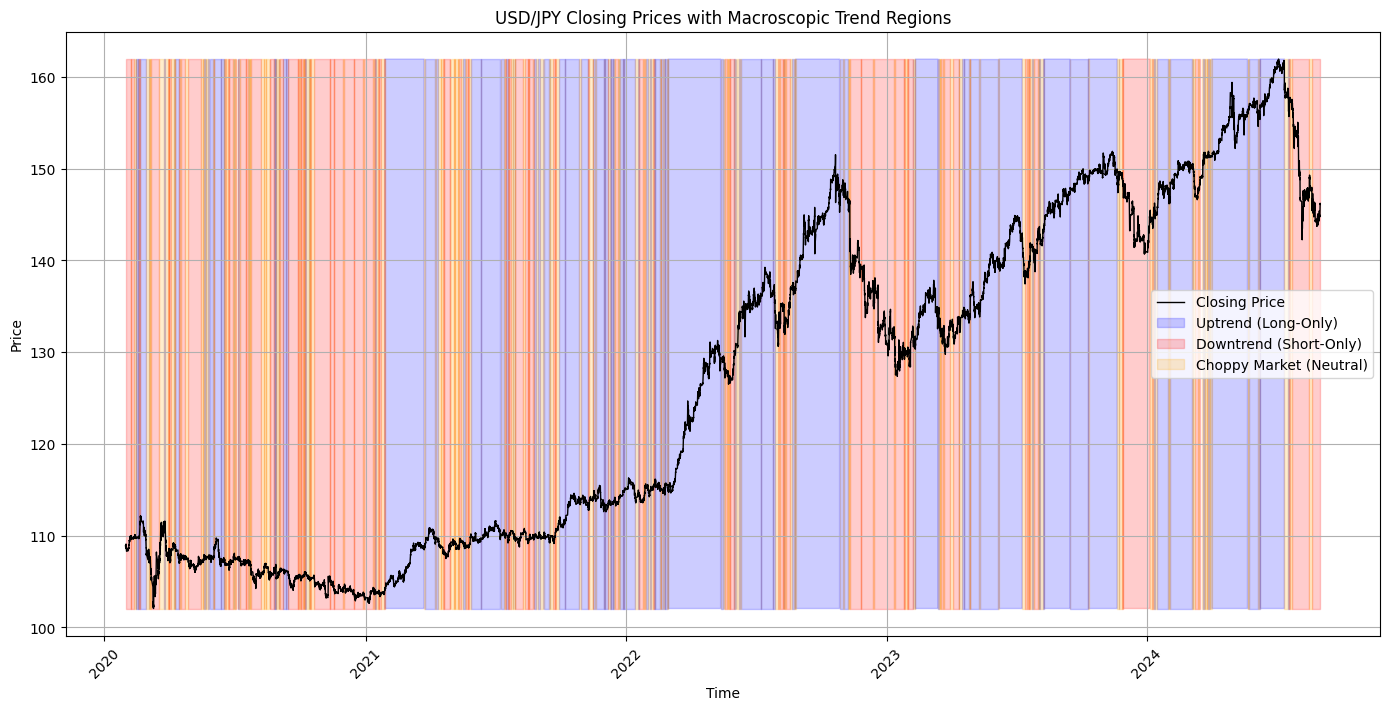

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
data = pd.read_csv('USDJPY.csv')  # Replace with your dataset path
data.dropna(inplace=True)
data["local_time_GMT"] = pd.to_datetime(data["local_time_GMT"])

# Step 2: Define moving averages (short-term and long-term)
ma_windows = {
    "24_Hour_MA": 24,    # 1 day = 24 hours
    "96_Hour_MA": 96,    # 4 days = 96 hours
    "1_Week_MA": 120,    # 1 week = 120 hours
    "2_Week_MA": 240,    # 2 weeks = 240 hours
    "3_Week_MA": 360,    # 3 weeks = 360 hours
    "4_Week_MA": 480     # 4 weeks = 480 hours
}

# Calculate moving averages
for label, window in ma_windows.items():
    data[label] = data['USDJPY_Close'].rolling(window=window).mean()

# Remove rows with NaN values after calculating moving averages
data.dropna(inplace=True)

# Step 3: Calculate slopes using sliding-window linear regression
def calculate_slopes(moving_avg_values, window_size):
    slopes = []
    for i in range(len(moving_avg_values) - window_size + 1):
        y = moving_avg_values[i:i + window_size]
        x = np.arange(window_size).reshape(-1, 1)  # Time as independent variable
        model = LinearRegression()
        model.fit(x, y)
        slopes.append(model.coef_[0])  # Extract slope
    return [np.nan] * (window_size - 1) + slopes  # Pad with NaNs to match length

# Calculate slopes for all MAs
for label, window_size in ma_windows.items():
    slope_label = f"{label}_Slope"
    data[slope_label] = calculate_slopes(data[label].values, window_size)

# Step 4: Classify slopes into trends
for label in ma_windows.keys():
    slope_label = f"{label}_Slope"
    trend_label = f"{label}_Trend"
    data[trend_label] = np.where(data[slope_label] > 0, 1, 0)

# Step 5: Calculate trend strengths
trend_columns = [f"{label}_Trend" for label in ma_windows.keys()]
data['Uptrend_Strength'] = data[trend_columns].sum(axis=1) / len(trend_columns)
data['Downtrend_Strength'] = 1 - data['Uptrend_Strength']

# Step 6: Microstructure Trend Detection
diff_threshold = 0.2  # 20% difference threshold for strong trends

def classify_microstructure_trend(row):
    diff = row['Uptrend_Strength'] - row['Downtrend_Strength']
    if diff > diff_threshold:
        return 'Uptrend'
    elif diff < -diff_threshold:
        return 'Downtrend'
    else:
        return 'Neutral'  # Covers both neutral and choppy cases

data['Microstructure_Trend'] = data.apply(classify_microstructure_trend, axis=1)

# Step 7: Monthly Trend Detection
# Partition data by month
data['Month'] = data['local_time_GMT'].dt.to_period('M')

# Calculate monthly trend proportions
monthly_trends = data.groupby('Month').agg(
    Uptrend_Days=('Uptrend_Strength', lambda x: (x > 0.5).sum()),
    Downtrend_Days=('Downtrend_Strength', lambda x: (x > 0.5).sum()),
    Total_Days=('local_time_GMT', 'count')
)
monthly_trends['Uptrend_Proportion'] = monthly_trends['Uptrend_Days'] / monthly_trends['Total_Days']
monthly_trends['Downtrend_Proportion'] = monthly_trends['Downtrend_Days'] / monthly_trends['Total_Days']

# Difference-based logic for monthly trends
difference_threshold_c = 0.2  # 20% difference threshold for monthly trends
def classify_monthly_trend(row):
    if row['Uptrend_Proportion'] - row['Downtrend_Proportion'] > difference_threshold_c:
        return 'Uptrend'
    elif row['Downtrend_Proportion'] - row['Uptrend_Proportion'] > difference_threshold_c:
        return 'Downtrend'
    else:
        return 'Neutral'

monthly_trends['Monthly_Trend'] = monthly_trends.apply(classify_monthly_trend, axis=1)

# Merge monthly trends back into the main dataset
data = data.merge(monthly_trends[['Monthly_Trend']], left_on='Month', right_index=True)

# Step 8: Blended Trend Logic
def blended_decision(row):
    if row['Microstructure_Trend'] in ['Uptrend', 'Downtrend']:
        return row['Microstructure_Trend']  # Microstructure takes priority
    else:
        return row['Monthly_Trend']  # Use macro trend for neutral microstructure

data['Blended_Trend'] = data.apply(blended_decision, axis=1)

# Step 9: Visualization
plt.figure(figsize=(14, 8))

# Plot the baseline closing price
plt.plot(data['local_time_GMT'], data['USDJPY_Close'], label='Closing Price', color='black', linewidth=1)

# Blended trend
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Blended_Trend'] == 'Uptrend'),
    color='blue',
    alpha=0.3,
    label='Blended Uptrend'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Blended_Trend'] == 'Downtrend'),
    color='red',
    alpha=0.3,
    label='Blended Downtrend'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Blended_Trend'] == 'Neutral'),
    color='orange',
    alpha=0.3,
    label='Blended Neutral'
)

plt.title("Blended Trend (Macro + Micro)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Step 9: Visualize the monthly trends
plt.figure(figsize=(14, 7))
plt.plot(data['local_time_GMT'], data['USDJPY_Close'], label='Closing Price', color='black', linewidth=1)

# Shade regions for monthly trends
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Monthly_Trend'] == 'Uptrend'),
    color='blue',
    alpha=0.2,
    label='Monthly Uptrend'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Monthly_Trend'] == 'Downtrend'),
    color='red',
    alpha=0.2,
    label='Monthly Downtrend'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Monthly_Trend'] == 'Neutral'),
    color='orange',
    alpha=0.2,
    label='Monthly Neutral'
)

# Chart details
plt.title("USD/JPY Closing Prices with Monthly Trend Regions (Option C)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Step 7: Visualize macroscopic trends
plt.figure(figsize=(14, 7))
plt.plot(data['local_time_GMT'], data['USDJPY_Close'], label='Closing Price', color='black', linewidth=1)

# Shade regions for macroscopic trends
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Microstructure_Trend'] == 'Uptrend'),
    color='blue',
    alpha=0.2,
    label='Uptrend (Long-Only)'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Microstructure_Trend'] == 'Downtrend'),
    color='red',
    alpha=0.2,
    label='Downtrend (Short-Only)'
)
plt.fill_between(
    data['local_time_GMT'],
    data['USDJPY_Close'].min(),
    data['USDJPY_Close'].max(),
    where=(data['Microstructure_Trend'] == 'Neutral'),
    color='orange',
    alpha=0.2,
    label='Choppy Market (Neutral)'
)

# Chart details
plt.title("USD/JPY Closing Prices with Macroscopic Trend Regions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


